# Serial Python

Before we get into parallel processing, let's first consider how the type of problems we'll consider are typical solved in a serial context. We'll focus on problems which always have the following form: 

In [1]:
def do_science(x):
    """For example:
    - training a neural network (hyperparameter tuning!)
    - getting results from a database
    - scraping some websites
    - read files
    - sampling monte-carlo style
    """
    return x ** 2  # we don't really do anything ;)

results = []
input_data = range(10)
for x in input_data:
    results.append(do_science(x))
print(results)

This typical structure (or "smell" ;) ) is pretty common and most likely all of you have something similar somewhere in your code. It's an excellent opportunity for leveraging parallelism to speed things up. However, first we'll rewrite this code using the builtin `map` function, it makes the code more compact and it will be easier to make this run in parallel. `map` takes a function and an iterable and applies the function to each iterable:

In [2]:
results = map(do_science, input_data)
print(list(results))

(watch out: `map` returns an iterator (->advanced python), you need to convert it to a list explicitly).

### Questions?

# Embarassingly-parallel Python
This type of problem is referred to as "embarrassingly parallel" problems. This indicates that they can be easily parallelized across threads or processes as they do not require interaction while running (they can also be run in serial!). For these types of problems, we can use the builtin `multiprocessing` module. It supports parallel versions of `map` which can be run either in parallel threads or parallel processes.

## Parallel threads
We first work with the `ThreadPool` available from the `multiprocessing.pool` module. We assume CPython in which the GIL prevent several threads from executing in parallel. However, for some use case, in particular those which are **I/O bound**, threading can be very useful. Consider for example obtaining data from some database: you would like to query a couple of measurements, and completing each of these queries may take some processing time on the server. Here we mimick this server-side processing time by merely sleeping.

In [3]:
from multiprocessing.pool import ThreadPool
import time

In [4]:
def query_database(x):
    """Query your database to retrieve awesome measurements."""
    print(f'querying data {x} start')
    time.sleep(x)  # mimicks (input-dependent) server-side processing
    y = x ** 2
    print(f'querying data {x} end')
    return y

In [5]:
l = [1, 8, 1.5, 2]  # some dummy queries

First, we use the builtin `map` function to perform the database query for each item in l:

In [6]:
%%time
result = list(map(query_database, l))
print(result)

querying data 1 start
querying data 1 end
querying data 8 start
querying data 8 end
querying data 1.5 start
querying data 1.5 end
querying data 2 start
querying data 2 end
[1, 64, 2.25, 4]
CPU times: user 13.7 ms, sys: 3.64 ms, total: 17.3 ms
Wall time: 12.5 s


Observations?
- queries processed in serial, one after the other
- total duration is the sum of the duration of each query 
- sleep (like I/O bound tasks) does not cause high CPU load

Now, we use use `ThreadPool` do perform these queries using two threads (here the `processes` argument actually refers to the number of threads):

In [7]:
%%time
with ThreadPool(processes=2) as pool:  # context manager providing a `ThreadPool` instance
    result = pool.map(query_database, l)
print(result)

querying data 1 start
querying data 8 start
querying data 1 end
querying data 1.5 start
querying data 1.5 end
querying data 2 start
querying data 2 end
querying data 8 end
[1, 64, 2.25, 4]
CPU times: user 14.2 ms, sys: 16.2 ms, total: 30.4 ms
Wall time: 8.02 s


Observations?
- results are identical to serial processing of queries; good!
- total duration is reduced: work (here: waiting for results) is distributed across threads
- allocation: queries are performed in order; thread 0 works on query 0, thread 1 on query 1, thread 0 on the rest while thread 1 is busy with query 1
- caveat: printing might get messy when printing from many threads
- caveat: optimal number of threads may be difficult to determine (more threads also means for switching!)
- caveat: load is not automatically balanced (`ThreadPool` can not know how long each query takes); in our example if long query is the last, total duration increases

In [8]:
l = [1, 1.5, 2, 8]  # some dummy queries

In [9]:
%%time
with ThreadPool(processes=2) as pool:
    result = pool.map(query_database, l)
print(result)

querying data 1 start
querying data 1.5 start
querying data 1 end
querying data 2 start
querying data 1.5 end
querying data 8 start
querying data 2 end
querying data 8 end
[1, 2.25, 4, 64]
CPU times: user 16.7 ms, sys: 3.58 ms, total: 20.3 ms
Wall time: 9.51 s


### Questions?

## Exercise
- TODO load and replace words in text files?

Now let's consider a compute-intense number-crunching task, for example tuning hyperparameters our fancy neural network model to squeeze out the additional 0.0002% increase in accuracy. Here we mimick the training by merely counting down from a large number (let's avoid cognitive overhead).

In [1]:
def train_neural_network(x):
    """Train your favourite neural network model."""
    print(f'training with {x} start')
    n = x * 2e7  # mimick compute-intense training
    while n > 0:
        n -= 1
    y = x ** 2
    print(f'training with {x} end')
    return y

In [11]:
l = [1, 8, 1.5, 2]  # some dummy simulations

Again, first, we use the builtin `map` function to perform the number crunching serially for each item in l:

In [12]:
%%time
result = list(map(train_neural_network, l))
print(result)

training with 1 start
training with 1 end
training with 8 start
training with 8 end
training with 1.5 start
training with 1.5 end
training with 2 start
training with 2 end
[1, 64, 2.25, 4]
CPU times: user 15.7 s, sys: 9.05 ms, total: 15.8 s
Wall time: 15.8 s


Observations:
- number crunching causes high CPU load (surprise! ;) )

Now, we use again use `ThreadPool` do parallelize this work using two threads:

In [13]:
%%time
with ThreadPool(processes=2) as pool:
    result = pool.map(train_neural_network, l)
print(result)

training with 1 start
training with 8 start
training with 1 end
training with 1.5 start
training with 1.5 end
training with 2 start
training with 2 end
training with 8 end
[1, 64, 2.25, 4]
CPU times: user 15.8 s, sys: 40.2 ms, total: 15.8 s
Wall time: 15.8 s


Observations?
- runtime (almost) identical to serial execution: GIL prevents simultaneous number crunching. :'(

# Multiprocessing in Python
For such tasks, we use the `ProcessPool`. In contrast to the `ThreadPool` this distributes work across multiple processes running separate instances of the Python interpreter. This allows you to circumvent the limitations of the GIL and achieve truly parallel code execution. For use cases which are **compute bound**, it is an excellent, simple-to-use option. As already introduced above, these use cases may include numerical simulations, sampling methods etc. Unfortunately, using multiple processes introduces some downsides, such as some overhead (time & memory) for launching processes and increased memory consumption (e.g., duplication of data; warning: depends on implementation and use case).

In [4]:
from multiprocessing.pool import Pool as ProcessPool

In [ ]:
%%time
with ProcessPool(processes=2) as pool:  # context manager providing a `Pool` instance
    result = pool.map(train_neural_network, l)
print(result)

Observations?
- result are identical to serial and threaded execution; good!
- runtime is reduced compare to both serial and threaded execution
- increased CPU load on multiple cores
- caveat: as before, no automatic load balancing, tasks are executed in order

### Parallel speedup
So how much faster does my code become when I'm increasing the number of processes? Here we investiate the relative speedup (T_parallel / T_serial) for an increasing number of processes. We use the same compute-bound function as before, but remove some of the annoying output and make it a bit shorter.

In [27]:
import time

def train_neural_network(x):
    """Train your favourite neural network model."""
    n = x * 1e6  # mimick compute-intense training
    while n > 0:
        n -= 1
    y = x ** 2
    return y

l = [2] * 16  # some dummy simulations of equal duration
times = []
for n_processes in range(1, 9):
    t0 = time.time()
    with ProcessPool(processes=n_processes) as pool:
        result = pool.map(train_neural_network, l)
    times.append(time.time() - t0)

print(times)

[2.085578680038452, 1.0615336894989014, 0.834465503692627, 0.7346930503845215, 0.8254823684692383, 0.7615199089050293, 0.7765102386474609, 0.8867688179016113]


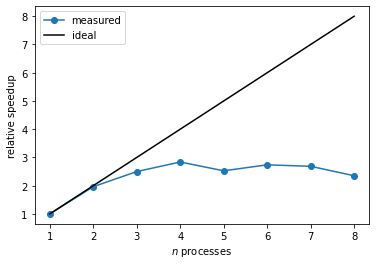

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

times = np.array(times)
plt.plot(range(1, 9), times[0] / times, marker='o', label='measured')
plt.plot(range(1, 9), range(1, 9), color='k', label='ideal')
plt.xlabel(r'$n$ processes')
plt.ylabel('relative speedup')
plt.legend()

Observations
- perfect speedup with 2 processes, good speedup until ~4 processes with decreasing benefits
- no benefits for more than 4 processes
- rule of thumb: benefits up to number of cores (OS also needs some compute: context switching; also hyperthreading does not seem to work well in my experience)

# Exercise
- TODO multiprocessing: scale resolution of images?
- TODO for ProcessPool: investigate behaviour for super short simulations -> speedup?

# TBD
- futures
- ~race conditions for threading~
- ~memory sharing for processes~

## Resources
https://www.youtube.com/watch?v=AG1soUh4-nU
